## Training an RNN to do binary addition

In [1]:
from __future__ import print_function, division, absolute_import

In [2]:
import numpy as np

import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Generating data

In [3]:
def generate_instance(bin_size=8, a=None, b=None):
    max_int = 2 ** bin_size - 1
    int2bin = lambda n: np.array([int(i) for i in np.binary_repr(n, bin_size)], dtype=np.int32)
    
    a = np.random.randint(0, max_int // 2) if a is None else a
    x1 = int2bin(a)
    
    b = np.random.randint(0, max_int // 2) if b is None else b
    x2 = int2bin(b)
    
    c = a + b
    y = int2bin(c)
    return x1,x2,y

In [4]:
def generate_batch(batch_size=100, bin_size=8):
    X = np.zeros(shape=[batch_size, bin_size, 2], dtype=np.int32)
    Y = np.zeros(shape=(batch_size, bin_size), dtype=np.int32)
    for i in range(batch_size):
        x1,x2,y = generate_instance(bin_size)
        X[i,:,0] = x1
        X[i,:,1] = x2
        Y[i,:] = y
    return X, Y

In [5]:
def ints2bins(ints, bin_size=8, concatenate=False):
    if concatenate:
        X = np.zeros([len(ints)**2, bin_size*2])
    else:
        X = np.zeros([len(ints)**2, bin_size, 2])
    
    Y = np.zeros([len(ints)**2, bin_size])
    
    for i, a in enumerate(ints):
        for j, b in enumerate(ints):
            row_idx = i+j
            x1,x2,y = generate_instance(bin_size, a, b)
            if concatenate:
                X[row_idx,:] = np.concatenate((x1,x2))
            else:
                X[row_idx,:,0] = x1
                X[row_idx,:,1] = x2
            Y[row_idx,:] = y
    return X,Y

In [6]:
# This is if we want to make test instances that never appeared in the training set
def generate_train_test_set(bin_size=8, test_ratio=0.2, concatenate=False):
    max_int = 2 ** (bin_size-1)
    
    test_ints = np.random.choice(range(max_int), int(test_ratio*max_int), replace=False)
    train_ints = [i for i in range(max_int) if i not in test_ints]
    
    train_X, train_Y = ints2bins(train_ints, bin_size, concatenate)
    test_X, test_Y = ints2bins(test_ints, bin_size, concatenate)
    
    return train_X, train_Y, test_X, test_Y

## First: let's see the performance of a single layer perceptron
### Spoiler: ~11 euclidean distance is as good as we could get with SLP
### Euclidean distance is used as loss function

<a href="http://www.saedsayad.com/artificial_neural_network_bkp.htm">
    Dr. Saed Sayad: Artificial Neural Network - Perceptron
   <img src="http://www.saedsayad.com/images/Perceptron_bkp_1.png">
    </a>

### 100 integers are used for training
### The other 28 ones are used for testing

In [7]:
seed = 48
bin_size=8
hidden_size = 16

np.random.seed(seed)

In [8]:
graph = tf.Graph()
with graph.as_default():
    tf.set_random_seed(seed)
    train_x = tf.placeholder(tf.float32, shape=[None,bin_size*2])
    train_y = tf.placeholder(tf.float32, shape=[None, bin_size])
    
    w = tf.Variable(tf.random_normal(shape=[bin_size*2, bin_size]))
    b = tf.Variable(tf.zeros(shape=[bin_size]))
    
    
    def model(data):
        return tf.nn.sigmoid(tf.add(tf.matmul(data,w),b))
    
    pred = model(train_x)
    loss = tf.reduce_mean(tf.norm(train_y-pred))
    optimizer = tf.train.AdamOptimizer().minimize(loss)

In [9]:
train_X, train_Y, test_X, test_Y = generate_train_test_set(concatenate=True)
train_X.shape, train_Y.shape

((10609, 16), (10609, 8))

In [10]:
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    training = dict()
    testing = dict()
    for j in range(20001):
        feed_dict = {train_x:train_X, train_y:train_Y}
        _, training_loss = sess.run([optimizer, loss], feed_dict=feed_dict)
        if j%10 == 0:
            training[j] = training_loss
            feed_dict = {train_x:test_X, train_y:test_Y}
            testing_loss = loss.eval(feed_dict=feed_dict)
            testing[j] = testing_loss
            if j%1000==0:
                print("Epoch {0}\nTraining Loss: {1}\nTesting Loss: {2}".format(j,training_loss, testing_loss))
                print("~"*40)

Epoch 0
Training Loss: 146.32882690429688
Testing Loss: 35.980751037597656
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1000
Training Loss: 81.6683349609375
Testing Loss: 21.79468536376953
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2000
Training Loss: 44.7773551940918
Testing Loss: 14.953043937683105
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3000
Training Loss: 27.01383399963379
Testing Loss: 12.422567367553711
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 4000
Training Loss: 18.337366104125977
Testing Loss: 11.56281852722168
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 5000
Training Loss: 14.013382911682129
Testing Loss: 11.301223754882812
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 6000
Training Loss: 11.826163291931152
Testing Loss: 11.22632884979248
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 7000
Training Loss: 10.686662673950195
Testing Loss: 11.21026611328125
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 8000
Training Loss: 10.065386772155762
Testing Loss: 1

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

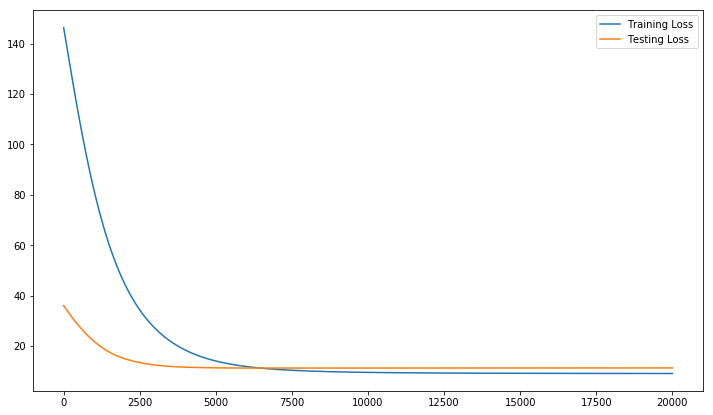

In [12]:
fig = plt.figure(figsize=(12,7))
plt.plot(sorted(training), [training[i] for i in sorted(training)])
plt.plot(sorted(testing), [testing[i] for i in sorted(testing)])
plt.legend(["Training Loss", "Testing Loss"])
plt.show()

## Now let's try RNN
<a href="http://peterroelants.github.io/posts/rnn_implementation_part02/">
    Peter's notes: How to implement a recurrent neural network
<img src="https://raw.githubusercontent.com/peterroelants/peterroelants.github.io/master/notebooks/RNN_implementation/img/SimpleRNN02_1.png"></a>